In [108]:
from pathlib import Path
path = Path('/home/ubuntu/code/looking-glass-')

## imports / setup

In [109]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [110]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


import torch
import re
import torch

from torchvision import datasets
from torchvision import transforms

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

from PIL import Image

In [111]:

models_list = ['candy', 'mosaic', 'rain_princess', 'udnie']

def stylize(inp_img, model):

    with torch.no_grad():
        # setup the process
        device = torch.device("cpu")
        state_dict = torch.load(path/f"""saved_models/{model}.pth""")

        # start net up earlywith torch.no_grad():
        style_model = TransformerNet()
        # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(device)

    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(inp_img)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = style_model(content_image)
        
    return output[0]

In [112]:
from functools import reduce

# cloze {
reduce(lambda x,y: x+y, [ i.numel() for i in style_model.parameters()])
# }

1679235

In [113]:
def convert_to_image(data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    return Image.fromarray(img)

def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

In [142]:
input_img = load_image(path/'trump.jpeg')

In [143]:
# input_img = input_img.convert('RGB')

In [144]:
input_img.size

(1160, 773)

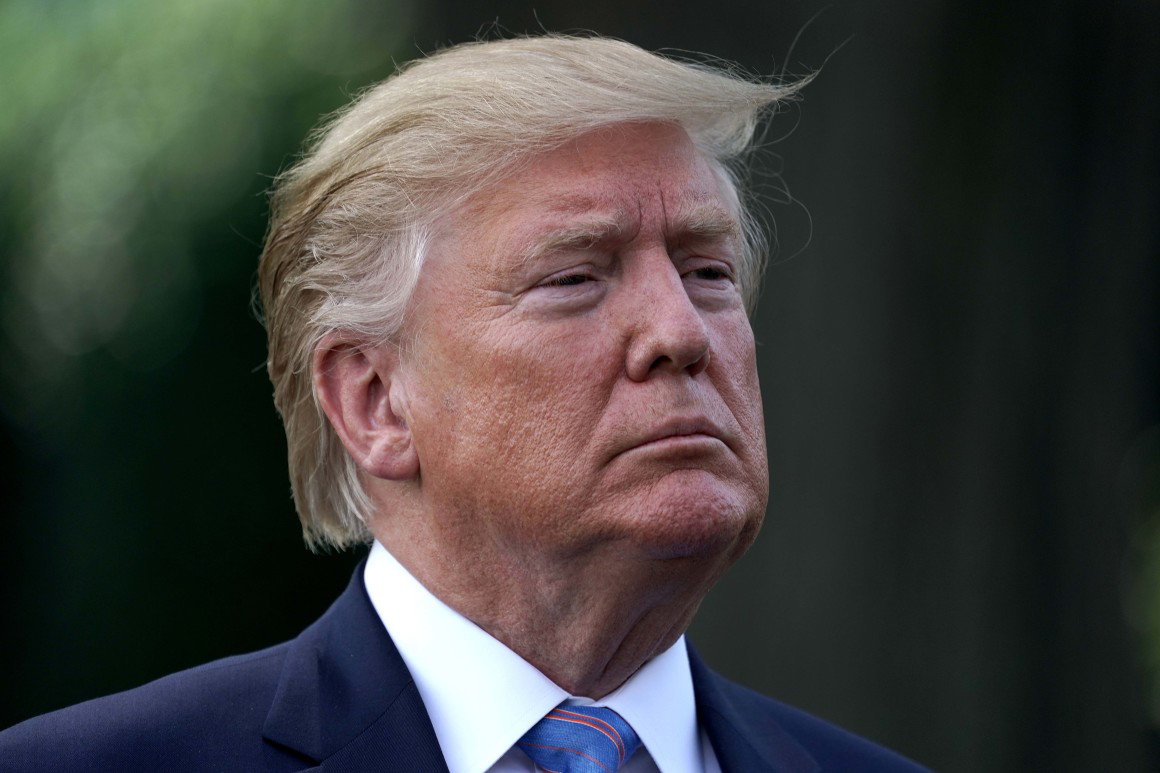

In [145]:
input_img

In [146]:
def generate_image(inp, model):
    output = stylize(input_img, model)
    return convert_to_image(output)

In [147]:
%%time
outputs = []

for m in models_list:
    im = generate_image(input_img, m)
    outputs.append(im)

CPU times: user 37.9 s, sys: 5.23 s, total: 43.1 s
Wall time: 23.9 s


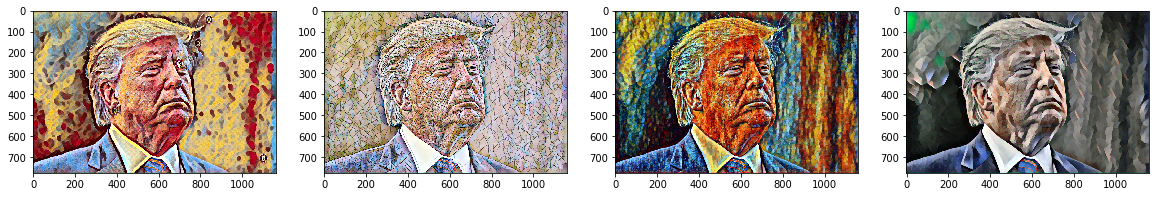

In [148]:
fig, axes = plt.subplots(1,len(models_list), figsize=(20,10))

for i, ax in enumerate(axes):
    ax.imshow(outputs[i])

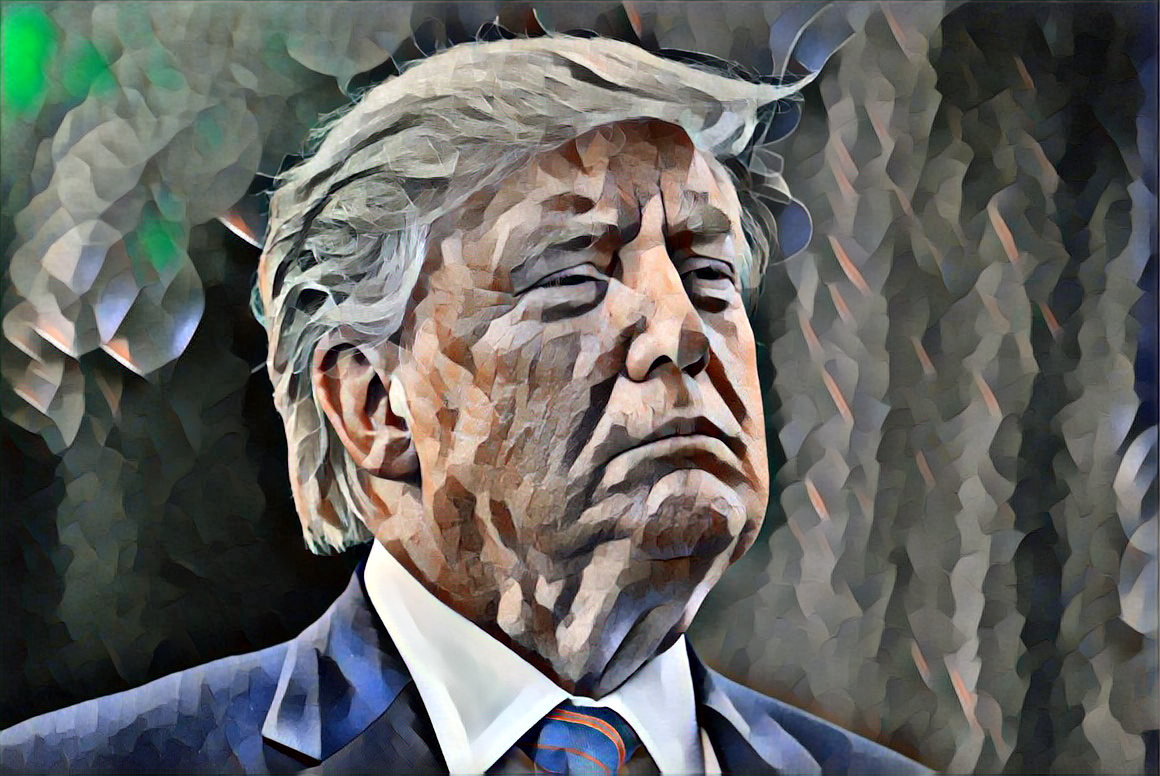

In [149]:
outputs[3]

In [150]:
outputs[1].save(path/'art/trump.jpeg')